In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from scipy.stats import shapiro, levene, mannwhitneyu, norm

In [2]:
df = pd.read_excel("Datasheet for fieldwork_Combined_Group 1.xlsx", header=1)

df = df.rename(
    columns={
        "Tree #": "tree_id",
        "Species (latin name)": "species",
        "Plot (mixed vs. mono)": "plot_type",
        "DBH (in cm)": "dbh",
        "Height (in m)": "height",
        "Aboveground biomass (in kg)": "agb",
        "LAI (m²/m²)": "lai",
        "Shannon index": "shannon",
        "Soil pH": "soil_pH",
        "IBP": "ibp",
        "Group": "group",
    }
)

df = df.loc[
    (~df["species"].str.contains(r"\(mort\)", case=False, na=False))
    & (~df["species"].str.contains(r" mort", case=False, na=False))
].reset_index(drop=True)

In [3]:
# remove rows with NAN
df = df.dropna().reset_index(drop=True)

In [4]:
df["species"].unique()

array(['Picea Abies', 'Fagus Sylvatica', 'Abies Alba', 'Quercus Robur',
       'Castanea Sativa', 'Picea', 'Sambucus Racemosa',
       'Corylus Avellana', 'Quercus Petraea', 'Castanea Dentata',
       'Pinus Sylvestris', 'Castanea sativa'], dtype=object)

In [5]:
# Unify species name
df.loc[df["species"]=="Picea", "species"] = "Picea Abies"  
df.loc[df["species"]=="Castanea sativa", "species"] = "Castanea Sativa"
df["species"].unique()

array(['Picea Abies', 'Fagus Sylvatica', 'Abies Alba', 'Quercus Robur',
       'Castanea Sativa', 'Sambucus Racemosa', 'Corylus Avellana',
       'Quercus Petraea', 'Castanea Dentata', 'Pinus Sylvestris'],
      dtype=object)

# Descriptive Statistics

In [6]:
vars_list = ["dbh", "height", "agb", "lai", "shannon", "soil_pH", "ibp"]

In [7]:
df[vars_list].describe()

,dbh,height,agb,lai,shannon,soil_pH,ibp
count,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000
mean,20.078208,14.457539,634.679856,5.291466,0.777027,4.958691,22.329843
std,16.624011,10.602421,2635.663825,1.360952,0.387937,0.296793,11.376388
min,0.808507,1.400000,0.033459,1.420000,0.000000,4.120000,8.000000
25%,4.451564,3.550000,4.569563,4.180000,0.562335,4.710000,12.000000
50%,16.233804,13.000000,61.290000,5.580000,0.759547,5.040000,22.000000
75%,32.945073,22.950000,481.029872,6.530000,1.060000,5.140000,29.000000
max,66.800000,40.000000,28195.001960,6.900000,1.520000,5.670000,42.000000


In [8]:
df.groupby("species").agg(count=("tree_id", "count"))

,count
species,
Abies Alba,47
Castanea Dentata,2
Castanea Sativa,5
Corylus Avellana,4
Fagus Sylvatica,52
Picea Abies,68
Pinus Sylvestris,8
Quercus Petraea,1
Quercus Robur,3


In [9]:
df.groupby("plot_type").agg(species_count=("species", "nunique"))

,species_count
plot_type,
Mixed,6
Mono,8


In [10]:
df.groupby(["plot_type", "group"]).agg(species_count=("species", "nunique"))

species_count
plot_type group               
Mixed     1                  4
          2                  3
          3                  4
          4                  3
          5                  2
          6                  2
          7                  4
          8                  3
          10                 3
Mono      1                  1
          2                  1
          3                  3
          4                  2
          5                  1
          6                  3
          7                  3
          8                  2
          10                 4

In [11]:
df.groupby(["plot_type", "species"]).agg(count=("tree_id", "count")).sort_values(by=["plot_type", "count"], ascending=False)

count
plot_type species                 
Mono      Picea Abies           31
          Abies Alba            28
          Fagus Sylvatica        9
          Pinus Sylvestris       8
          Corylus Avellana       4
          Castanea Sativa        3
          Castanea Dentata       2
          Sambucus Racemosa      1
Mixed     Fagus Sylvatica       43
          Picea Abies           37
          Abies Alba            19
          Quercus Robur          3
          Castanea Sativa        2
          Quercus Petraea        1

### tree-level metrics comparison between plots

In [12]:
df.groupby("plot_type")[["dbh", "height", "agb"]].agg(["mean", "var"])
# there are extreme values in agb, so the variance is very high

dbh                 height                     agb  \
                mean         var       mean         var        mean   
plot_type                                                             
Mixed      16.376549  291.513268  10.728286   77.918041  769.903911   
Mono       24.597675  223.473544  19.010698  117.782592  469.580719   

                         
                    var  
plot_type                
Mixed      1.234762e+07  
Mono       3.701267e+05

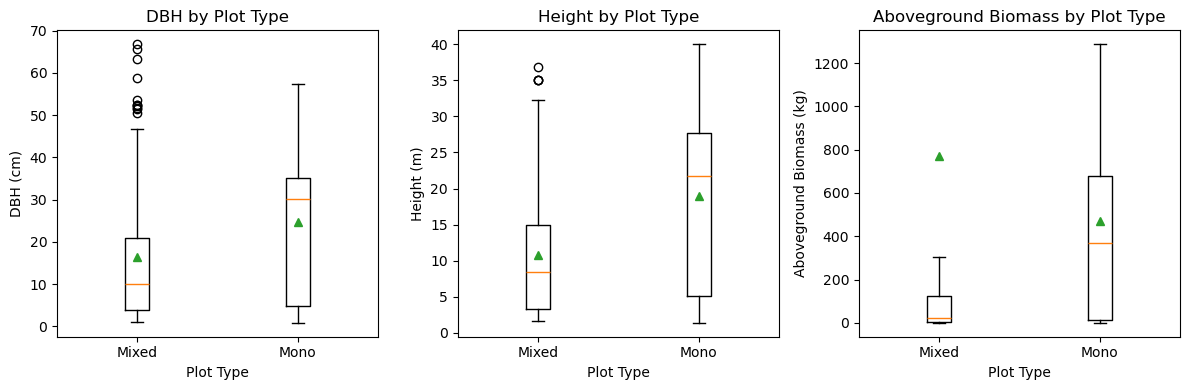

In [13]:
# tree-level metrics comparison between plots
fig, axes = plt.subplots(1, 3, figsize=(12, 4)) 

axes[0].boxplot([
    df.groupby("plot_type")["dbh"].get_group("Mixed").dropna().values,
    df.groupby("plot_type")["dbh"].get_group("Mono").dropna().values
], tick_labels=["Mixed", "Mono"], showmeans=True)
axes[0].set_title("DBH by Plot Type")
axes[0].set_xlabel("Plot Type")
axes[0].set_ylabel("DBH (cm)")

axes[1].boxplot([
    df.groupby("plot_type")["height"].get_group("Mixed").dropna().values,
    df.groupby("plot_type")["height"].get_group("Mono").dropna().values
], tick_labels=["Mixed", "Mono"], showmeans=True)
axes[1].set_title("Height by Plot Type")
axes[1].set_xlabel("Plot Type")
axes[1].set_ylabel("Height (m)")

axes[2].boxplot([
    df.groupby("plot_type")["agb"].get_group("Mixed").dropna().values,
    df.groupby("plot_type")["agb"].get_group("Mono").dropna().values
], tick_labels=["Mixed", "Mono"], showfliers=False, showmeans=True)
# exclude outliers for better visualization
axes[2].set_title("Aboveground Biomass by Plot Type")
axes[2].set_xlabel("Plot Type")
axes[2].set_ylabel("Aboveground Biomass (kg)")

plt.subplots_adjust(left=0.08, wspace=0.4)
plt.tight_layout()
plt.show()

### plot-level metrics comparison between plots

In [24]:
df.groupby("plot_type")[["lai", "shannon", "soil_pH", "ibp"]].agg(["unique"]).map(
    lambda x: (
        {"mean": round(float(np.mean(x)), 2), "var": round(float(np.var(x, ddof=1)), 2)}
        if isinstance(x, (list, np.ndarray)) and len(x) > 0
        else np.nan
    )
)

,lai,shannon,soil_pH,ibp
,unique,unique,unique,unique
plot_type,,,,
Mixed,"{'mean': 5.43, 'var': 3.29}","{'mean': 0.92, 'var': 0.1}","{'mean': 5.01, 'var': 0.05}","{'mean': 27.71, 'var': 118.9}"
Mono,"{'mean': 4.54, 'var': 1.11}","{'mean': 0.67, 'var': 0.23}","{'mean': 4.98, 'var': 0.22}","{'mean': 13.83, 'var': 23.37}"


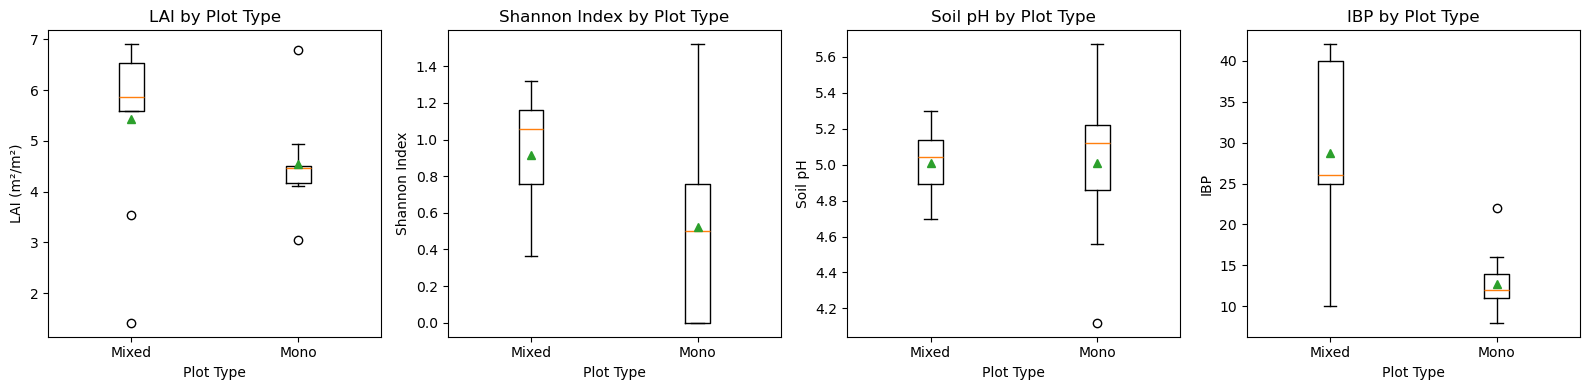

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4)) 

axes[0].boxplot([
    df.groupby(["plot_type", "group"])["lai"].unique().xs("Mixed", level="plot_type"),
    df.groupby(["plot_type", "group"])["lai"].unique().xs("Mono", level="plot_type"),
], tick_labels=["Mixed", "Mono"], showmeans=True)
axes[0].set_title("LAI by Plot Type")
axes[0].set_xlabel("Plot Type")
axes[0].set_ylabel("LAI (m²/m²)")

axes[1].boxplot([
    df.groupby(["plot_type", "group"])["shannon"].unique().xs("Mixed", level="plot_type"),
    df.groupby(["plot_type", "group"])["shannon"].unique().xs("Mono", level="plot_type"),
], tick_labels=["Mixed", "Mono"], showmeans=True)
axes[1].set_title("Shannon Index by Plot Type")
axes[1].set_xlabel("Plot Type")
axes[1].set_ylabel("Shannon Index")

axes[2].boxplot([
    df.groupby(["plot_type", "group"])["soil_pH"].unique().xs("Mixed", level="plot_type"),
    df.groupby(["plot_type", "group"])["soil_pH"].unique().xs("Mono", level="plot_type"),
], tick_labels=["Mixed", "Mono"], showmeans=True)
axes[2].set_title("Soil pH by Plot Type")
axes[2].set_xlabel("Plot Type")
axes[2].set_ylabel("Soil pH")

axes[3].boxplot([
    df.groupby(["plot_type", "group"])["ibp"].unique().xs("Mixed", level="plot_type"),
    df.groupby(["plot_type", "group"])["ibp"].unique().xs("Mono", level="plot_type"),
], tick_labels=["Mixed", "Mono"], showmeans=True)
axes[3].set_title("IBP by Plot Type")
axes[3].set_xlabel("Plot Type")
axes[3].set_ylabel("IBP")

plt.subplots_adjust(left=0.05, wspace=0.4)
plt.tight_layout()
plt.show()

### tree-level metrics comparison between the 3 most common species

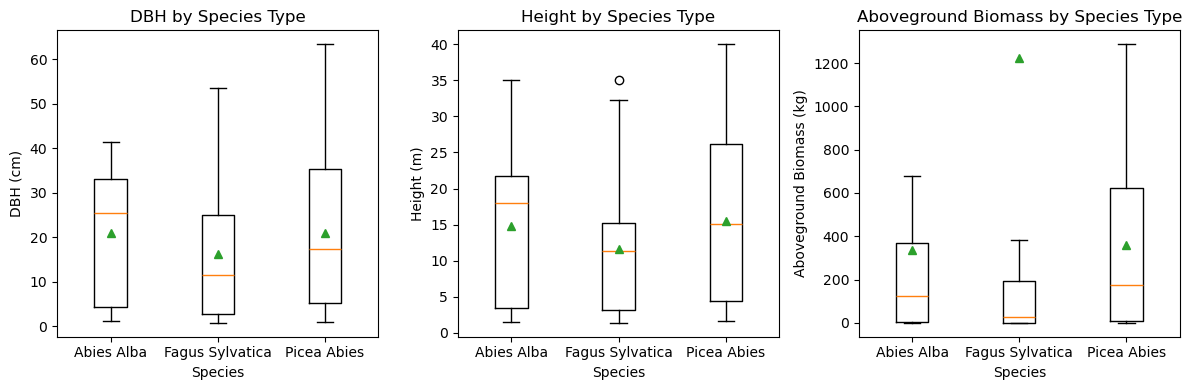

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4)) 

axes[0].boxplot([
    df.groupby("species")["dbh"].get_group("Abies Alba").dropna().values,
    df.groupby("species")["dbh"].get_group("Fagus Sylvatica").dropna().values,
    df.groupby("species")["dbh"].get_group("Picea Abies").dropna().values,
], tick_labels=["Abies Alba", "Fagus Sylvatica", "Picea Abies"], showmeans=True)
axes[0].set_title("DBH by Species Type")
axes[0].set_xlabel("Species")
axes[0].set_ylabel("DBH (cm)")

axes[1].boxplot([
    df.groupby("species")["height"].get_group("Abies Alba").dropna().values,
    df.groupby("species")["height"].get_group("Fagus Sylvatica").dropna().values,
    df.groupby("species")["height"].get_group("Picea Abies").dropna().values,
], tick_labels=["Abies Alba", "Fagus Sylvatica", "Picea Abies"], showmeans=True)
axes[1].set_title("Height by Species Type")
axes[1].set_xlabel("Species")
axes[1].set_ylabel("Height (m)")

axes[2].boxplot([
    df.groupby("species")["agb"].get_group("Abies Alba").dropna().values,
    df.groupby("species")["agb"].get_group("Fagus Sylvatica").dropna().values,
    df.groupby("species")["agb"].get_group("Picea Abies").dropna().values,
], tick_labels=["Abies Alba", "Fagus Sylvatica", "Picea Abies"], showfliers=False, showmeans=True)
# exclude outliers for better visualization
axes[2].set_title("Aboveground Biomass by Species Type")
axes[2].set_xlabel("Species")
axes[2].set_ylabel("Aboveground Biomass (kg)")

plt.subplots_adjust(left=0.08, wspace=0.4)
plt.tight_layout()
plt.show()

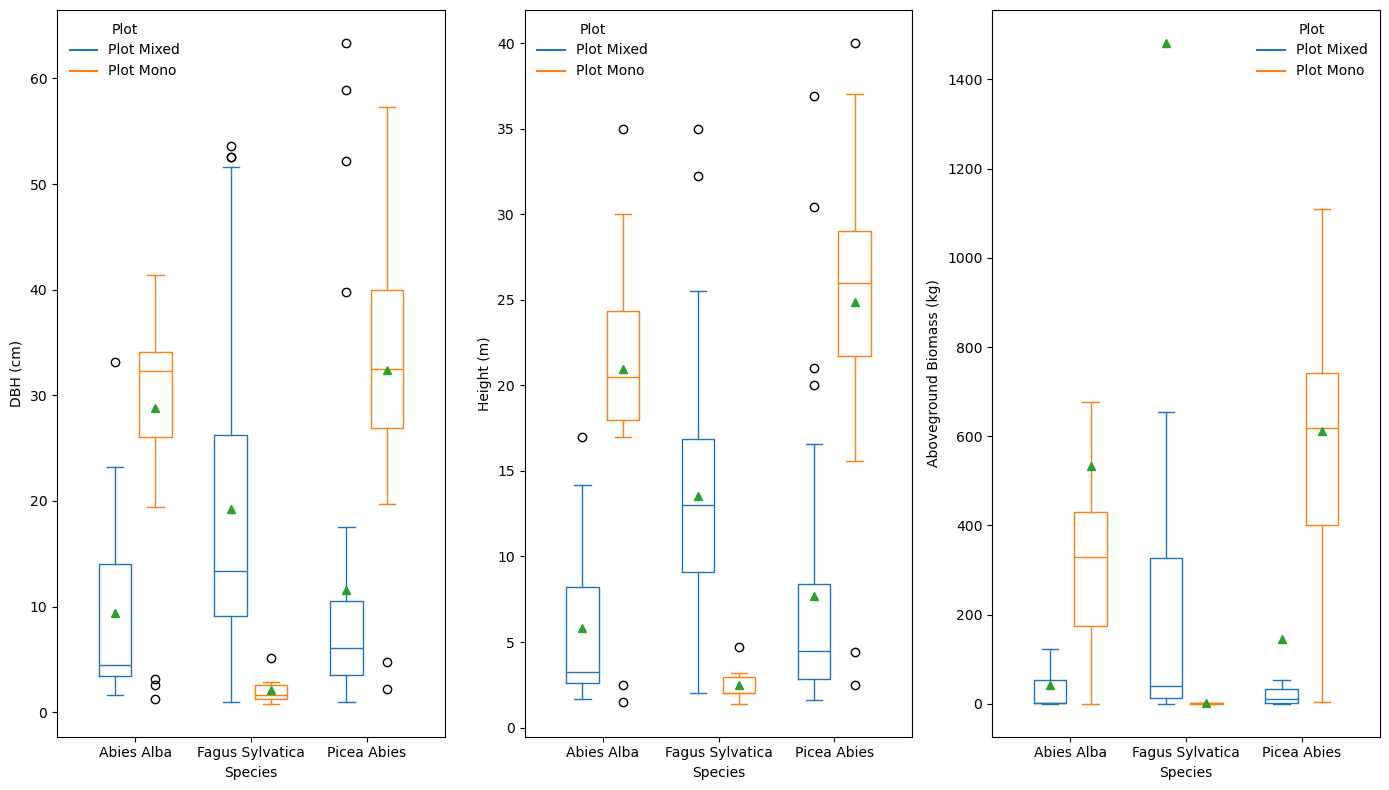

In [17]:
species_order = ["Abies Alba", "Fagus Sylvatica", "Picea Abies"]
plots = sorted(df["plot_type"].dropna().unique().tolist())

def grouped_boxplot(ax, df, value_col, ylabel, show_fliers=True):
    import numpy as np
    x = np.arange(1, len(species_order) + 1)
    width = 0.35  
    offsets = np.linspace(-width/2, width/2, num=len(plots))

    # draw boxes for each plot with a slight x-offset
    for k, pl in enumerate(plots):
        d = df[df["plot_type"] == pl]
        data = [d.loc[d["species"] == sp, value_col].dropna().values for sp in species_order]
        bp = ax.boxplot(
            data,
            positions=x + offsets[k],
            widths=width * 0.8,
            showmeans=True,
            showfliers=show_fliers,
            patch_artist=False  # ensures no color fill
        )
        
        # optional: color outlines differently per plot
        color = f"C{k}"  # matplotlib default color cycle
        for element in ['boxes', 'whiskers', 'caps', 'medians', 'means']:
            plt.setp(bp[element], color=color)

        ax.plot([], [], color=color, label=f"Plot {pl}")

    ax.set_xticks(x, species_order, rotation=0)
    ax.set_xlabel("Species")
    ax.set_ylabel(ylabel)
    ax.legend(title="Plot", frameon=False)

fig, axes = plt.subplots(1, 3, figsize=(14, 8), sharex=False)
grouped_boxplot(axes[0], df, "dbh", "DBH (cm)")
grouped_boxplot(axes[1], df, "height", "Height (m)")
grouped_boxplot(axes[2], df, "agb", "Aboveground Biomass (kg)", show_fliers=False)
plt.tight_layout()
plt.show()

# Group Comparisons

In [18]:
# function for ANOVA test and Tukey HSD post-hoc test
def anova_tukey(data, dependent_var, independent_var):
    print("=" * 60)
    print(f"Test for: {dependent_var}")
    print("=" * 60)

    model = ols(f"{dependent_var} ~ C({independent_var})", data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("ANOVA results:")
    print(anova_table)

    if anova_table.loc[f"C({independent_var})","PR(>F)"] < 0.05:
        print("\nTukey HSD post-hoc test results:")
        tukey = sm.stats.multicomp.pairwise_tukeyhsd(
            endog=data[dependent_var],
            groups=data[independent_var],
            alpha=0.05
        )
        print(tukey)
    else:
        print("\nNo significant differences found among groups.")

### Group comparison between Mixed & Mono

In [19]:
for var in vars_list:
    anova_tukey(df, var, "plot_type")

Test for: dbh
ANOVA results:
                    sum_sq     df          F    PR(>F)
C(plot_type)   3195.338750    1.0  12.246741  0.000581
Residual      49312.631172  189.0        NaN       NaN

Tukey HSD post-hoc test results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
 Mixed   Mono   8.2211 0.0006 3.5871 12.8552   True
---------------------------------------------------
Test for: height
ANOVA results:
                    sum_sq     df          F        PR(>F)
C(plot_type)   3243.157494    1.0  33.836979  2.519909e-08
Residual      18114.996650  189.0        NaN           NaN

Tukey HSD post-hoc test results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower   upper  reject
--------------------------------------------------
 Mixed   Mono   8.2824   0.0 5.4738 11.0911   True
--------------------------------------------------
Test for: agb

### Group comparison between species

In [20]:
for var in vars_list:
    anova_tukey(df, var, "species")

Test for: dbh
ANOVA results:
                  sum_sq     df         F   PR(>F)
C(species)  10082.839831    9.0  4.779646  0.00001
Residual    42425.130091  181.0       NaN      NaN

Tukey HSD post-hoc test results:
            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
     group1            group2      meandiff p-adj    lower    upper   reject
----------------------------------------------------------------------------
      Abies Alba  Castanea Dentata -18.0375 0.8308  -53.4492  17.3742  False
      Abies Alba   Castanea Sativa  -8.7588 0.9689  -31.8306  14.3129  False
      Abies Alba  Corylus Avellana -18.7885 0.3587  -44.3343   6.7573  False
      Abies Alba   Fagus Sylvatica  -4.6315 0.8894   -14.503   5.2399  False
      Abies Alba       Picea Abies    0.123    1.0   -9.1807   9.4268  False
      Abies Alba  Pinus Sylvestris  11.6495 0.6075   -7.1091  30.4081  False
      Abies Alba   Quercus Petraea  45.8625 0.0961   -3.7036  95.4286  False
      Abies Al

# Preparation for hypothesis test

### Normally distribution or not?

In [21]:
# shapiro test for normality
for var in vars_list:
    stat, p = shapiro(df[var])
    print("=" * 60)
    print(f"Shapiro-Wilk Test for: {var}")
    print("=" * 60)
    print(f"Statistic: {stat}, p-value: {p}")
    if p > 0.05:
        print("The data is normally distributed.\n")
    else:
        print("The data is not normally distributed.\n")

Shapiro-Wilk Test for: dbh
Statistic: 0.9051963944794085, p-value: 1.0530999529005723e-09
The data is not normally distributed.

Shapiro-Wilk Test for: height
Statistic: 0.912770776187247, p-value: 3.3503905780349325e-09
The data is not normally distributed.

Shapiro-Wilk Test for: agb
Statistic: 0.20309245749403204, p-value: 7.473010166943037e-28
The data is not normally distributed.

Shapiro-Wilk Test for: lai
Statistic: 0.8989573076009973, p-value: 4.2392043574785176e-10
The data is not normally distributed.

Shapiro-Wilk Test for: shannon
Statistic: 0.9532946037218886, p-value: 6.376142804554832e-06
The data is not normally distributed.

Shapiro-Wilk Test for: soil_pH
Statistic: 0.9257774942514975, p-value: 2.8558434860910582e-08
The data is not normally distributed.

Shapiro-Wilk Test for: ibp
Statistic: 0.8869880204624716, p-value: 8.149994973769036e-11
The data is not normally distributed.



Note: Since the raw data did not meet normality assumptions (Shapiro–Wilk test, p < 0.05), log-transformed values were used for further analyses.

### log transform

In [22]:
df_log = df.copy()
df_log[vars_list] = df_log[vars_list].apply(lambda x: np.log(x+1))

In [23]:
df_log

,tree_id,species,plot_type,dbh,height,agb,lai,shannon,soil_pH,ibp,group
0,1,Picea Abies,Mixed,1.504390,1.504077,0.948085,2.002830,0.775215,1.773256,3.258097,1
1,2,Picea Abies,Mixed,2.572290,2.424803,3.581097,2.002830,0.775215,1.773256,3.258097,1
2,3,Fagus Sylvatica,Mixed,0.952256,1.589235,0.284802,2.002830,0.775215,1.773256,3.258097,1
3,4,Fagus Sylvatica,Mixed,2.079794,2.388763,2.705505,2.002830,0.775215,1.773256,3.258097,1
4,5,Abies Alba,Mixed,3.091427,2.721295,4.811626,2.002830,0.775215,1.773256,3.258097,1
...,...,...,...,...,...,...,...,...,...,...,...
186,205,Picea Abies,Mixed,0.992461,1.075002,0.818215,1.909543,0.722706,1.798404,3.713572,10
187,206,Fagus Sylvatica,Mixed,3.962388,3.278653,10.003262,1.909543,0.722706,1.798404,3.713572,10
188,207,Picea Abies,Mixed,1.833429,1.673351,2.960662,1.909543,0.722706,1.798404,3.713572,10
189,208,Abies Alba,Mixed,2.749447,2.626117,5.842109,1.909543,0.722706,1.798404,3.713572,10


In [28]:
df_mixed = df_log[df_log["plot_type"] == "Mixed"].reset_index(drop=True)
df_mono = df_log[df_log["plot_type"] == "Mono"].reset_index(drop=True)

# Hypothesis 1

# Hypothesis 2

In [30]:
# shapiro test for normality after log transformation
for var in ["dbh", "height", "agb"]:
    print(f"\n{var} normally distribution test:")
    print("Monoculture:", shapiro(df_mono[var]).pvalue)
    print("Mixed:", shapiro(df_mixed[var]).pvalue)


dbh normally distribution test:
Monoculture: 5.008203915068016e-11
Mixed: 0.010047266296953171

height normally distribution test:
Monoculture: 1.1084814076973558e-10
Mixed: 0.0007658707260631962

agb normally distribution test:
Monoculture: 2.246856879623122e-09
Mixed: 0.00025687325685184623


Note: the log-transformed data still violated normality assumptions (Shapiro–Wilk test, p < 0.05)

In [29]:
# levene test for homogeneity of variances
for var in ["dbh", "height", "agb"]:
    stat, p = levene(df_mono[var], df_mixed[var])
    print(f"{var} Levene test p = {p:.4f}")

dbh Levene test p = 0.7153
height Levene test p = 0.7491
agb Levene test p = 0.5761


Note: Levene’s test indicated homogeneity of variances (p > 0.05)

In [33]:
# non-parametric Mann–Whitney U tests
for var in ["dbh", "height", "agb"]:
    stat, p = mannwhitneyu(df_mono[var], df_mixed[var], alternative='greater')
    print(f"{var}: U = {stat:.3f}, p = {p:.4f}")

dbh: U = 5727.500, p = 0.0007
height: U = 6358.000, p = 0.0000
agb: U = 5999.000, p = 0.0000


Note: Since the log-transformed data still violated normality assumptions (Shapiro–Wilk test, p < 0.05), non-parametric Mann–Whitney U tests were conducted to compare monoculture and mixed plantations.
Results showed that DBH, Height and AGB were significantly higher in monoculture plots (p < 0.05), supporting the hypothesis that monoculture plantations exhibit higher wood productivity.

In [35]:
def mannwhitney_effect_size(x, y):
    n1, n2 = len(x), len(y)
    stat, p = mannwhitneyu(x, y, alternative='greater')
    mean_U = n1 * n2 / 2
    sd_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
    z = (stat - mean_U) / sd_U
    r = z / np.sqrt(n1 + n2)
    return stat, p, r

In [36]:
for var in ["dbh", "height", "agb"]:
    stat, p, r = mannwhitney_effect_size(df_mono[var], df_mixed[var])
    print(f"{var}: U={stat:.2f}, p={p:.4f}, r={r:.3f}")

dbh: U=5727.50, p=0.0007, r=0.231
height: U=6358.00, p=0.0000, r=0.351
agb: U=5999.00, p=0.0000, r=0.282


Note: The effect sizes (r = 0.23–0.35) indicate small to medium effects, suggesting a consistent, though not large, productivity advantage in monocultures.